In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt


In [2]:
def read_logs(fpath):
    f = open(fpath, 'r')
    lines = f.readlines()
    f.close()
    
    data = list( map( lambda s: s.strip().split(), lines) )
    
    df = pl.DataFrame( data,
                       orient ='row',
                       schema = {'n_epochs' : pl.Int32, 'initial_lr' : pl.Float32,
                                 'decay_rate' : pl.Float32, 'regularization_alpha' : pl.Float32,
                                 'elapsed_time' : pl.Float32, 'max_loss' : pl.Float64, 'min_loss' : pl.Float64 } )

    return df


In [3]:
def make_df():
    py_df = read_logs('./logs/py_log.txt')
    cpp_df = read_logs('./logs/cpp_log.txt')

    df = pl.DataFrame(data = np.zeros( shape= (py_df.shape[0], py_df.shape[1]+3)),
        schema = {'n_epochs' : pl.Int32, 'initial_lr' : pl.Float32,
                                'decay_rate' : pl.Float32, 'regularization_alpha' : pl.Float32,
                                'cpp_elapsed_time' : pl.Float32, 'cpp_max_loss' : pl.Float64, 'cpp_min_loss' : pl.Float64,
                                'py_elapsed_time' : pl.Float32, 'py_max_loss' : pl.Float64, 'py_min_loss' : pl.Float64} )

    
    df = df.with_columns(
     [pl.lit(cpp_df[c]).alias(c) for c in py_df.columns[:4]] + 
     [pl.lit(cpp_df[c]).alias('cpp_' + c) for c in cpp_df.columns[4:]] +
     [pl.lit(py_df[c]).alias('py_' + c) for c in py_df.columns[4:]]
    )
    
    return df
    

In [4]:
def plot_lossVSalpha(df, ix):
    
    df = df.group_by(
    ["n_epochs", "initial_lr", "decay_rate"]).agg(
        pl.col("regularization_alpha"), pl.col("cpp_min_loss"), pl.col("py_min_loss") )
    
    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | n_epochs: {d['n_epochs'][0]} | initial_lr: {d['initial_lr'][0]:.5e} | decay_rate: {d['decay_rate'][0]:.1f}  "
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(1,1)
    ax.set_xlabel('regularization_alpha')
    ax.set_ylabel('min_loss')
    ax.set_title( title )
    
    ax.plot(data['regularization_alpha'][0], data['cpp_min_loss'][0],
            c='blue', marker='*', mfc='red', mec='red', label='cpp')
    
    ax.plot(data['regularization_alpha'][0], data['py_min_loss'][0],
            c='green', marker='*', mfc='orange', mec='orange', label='py')

    ax.legend()
    

In [5]:
def plot_lossVSdecay(df, ix):
    
    df = df.group_by(
    ["n_epochs", "initial_lr", "regularization_alpha"]).agg(
        pl.col("decay_rate"), pl.col("cpp_min_loss"), pl.col("py_min_loss") )

    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | n_epochs: {d['n_epochs'][0]} | initial_lr: {d['initial_lr'][0]:.5e}\
    | regularization_alpha: {d['regularization_alpha'][0]:.5e}  "
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(1,1)
    ax.set_xlabel('decay_rate')
    ax.set_ylabel('min_loss')
    ax.set_title( title )
    
    ax.plot(data['decay_rate'][0], data['cpp_min_loss'][0],
            c='blue', marker='*', mfc='red', mec='red', label='cpp')
    
    ax.plot(data['decay_rate'][0], data['py_min_loss'][0],
            c='green', marker='*', mfc='orange', mec='orange', label='py')

    ax.legend()
    

In [6]:
def plot_lossVSlr(df, ix):
    
    df = df.group_by(
    ["n_epochs","decay_rate", "regularization_alpha"]).agg(
        pl.col("initial_lr"), pl.col("cpp_min_loss"), pl.col("py_min_loss") )

    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | n_epochs: {d['n_epochs'][0]} | decay_rate: {d['decay_rate'][0]:.2e}\
    | regularization_alpha: {d['regularization_alpha'][0]:.5e}  "
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(1,1)
    ax.set_xlabel("initial_lr")
    ax.set_ylabel('min_loss')
    ax.set_title( title )
    
    ax.plot(data['initial_lr'][0], data['cpp_min_loss'][0],
            c='blue', marker='*', mfc='red', mec='red', label='cpp')
    
    ax.plot(data['initial_lr'][0], data['py_min_loss'][0],
            c='green', marker='*', mfc='orange', mec='orange', label='py')

    ax.legend()
    

In [7]:
def plot_lossVSepochs(df, ix):
    
    df = df.group_by(
    ["decay_rate", "initial_lr", "regularization_alpha"]).agg(
        pl.col("n_epochs"), pl.col("cpp_min_loss"), pl.col("py_min_loss") )

    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | initial_lr: {d['initial_lr'][0]} | decay_rate: {d['decay_rate'][0]:.2e}\
    | regularization_alpha: {d['regularization_alpha'][0]:.5e}  "
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(1,1)
    ax.set_xlabel("n_epochs")
    ax.set_ylabel('min_loss')
    ax.set_title( title )
    
    ax.plot(data['n_epochs'][0], data['cpp_min_loss'][0],
            c='blue', marker='*', mfc='red', mec='red', label='cpp')
    
    ax.plot(data['n_epochs'][0], data['py_min_loss'][0],
            c='green', marker='*', mfc='orange', mec='orange', label='py')

    ax.legend()
    

In [8]:
df = make_df()
df


n_epochs,initial_lr,decay_rate,regularization_alpha,cpp_elapsed_time,cpp_max_loss,cpp_min_loss,py_elapsed_time,py_max_loss,py_min_loss
i32,f32,f32,f32,f32,f64,f64,f32,f64,f64
128,1.0,0.1,0.01,0.212116,0.052932,0.0233311,0.278462,0.097762,0.097732
128,1.0,0.1,0.005,0.231826,0.176766,0.0226428,0.285852,2.0240e6,1.3872e6
128,1.0,0.1,0.001,0.187286,0.111093,0.0218109,0.24547,1.0996e16,4.4440e15
128,1.0,0.1,0.0005,0.181586,0.139241,0.0218398,0.255447,6.8980e16,2.3233e16
128,1.0,0.1,0.0001,0.186608,0.026944,0.021606,0.319497,6.9301e16,1.6262e16
…,…,…,…,…,…,…,…,…,…
4096,0.0001,0.7,0.005,5.92214,0.0810528,0.0802429,7.696448,0.256622,0.037952
4096,0.0001,0.7,0.001,5.64952,0.134694,0.133059,7.475558,0.223738,0.035941
4096,0.0001,0.7,0.0005,5.85705,0.0302584,0.0301617,8.191315,0.263359,0.038333


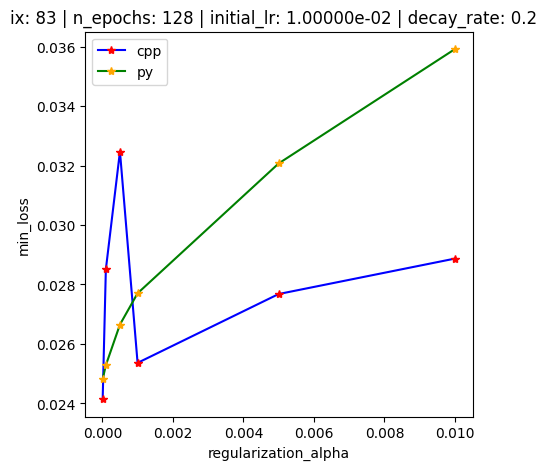

In [17]:
plot_lossVSalpha(df, None) 


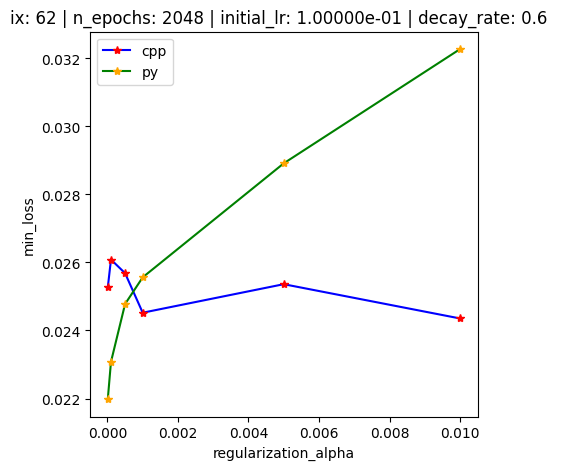

In [18]:
plot_lossVSalpha(df, None) 


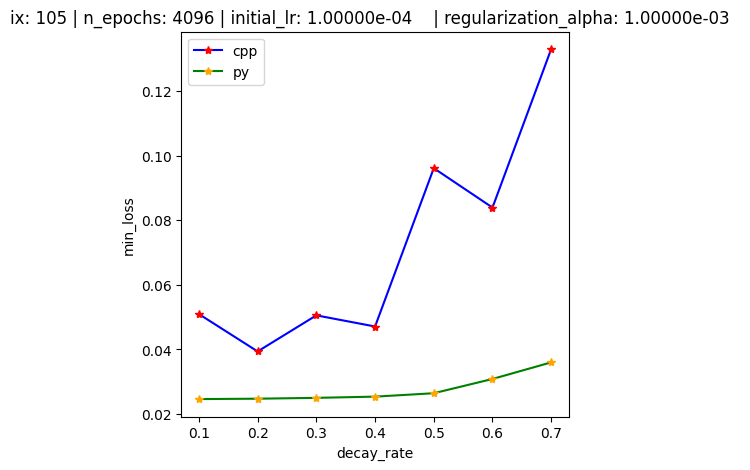

In [19]:
plot_lossVSdecay(df, None) 


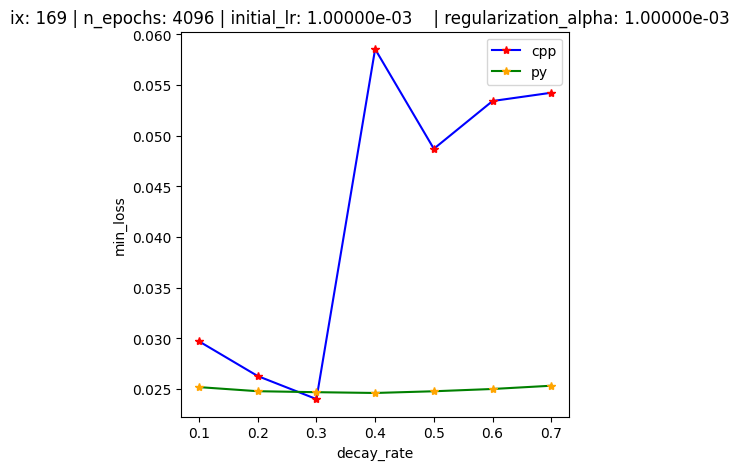

In [20]:
plot_lossVSdecay(df, None) 


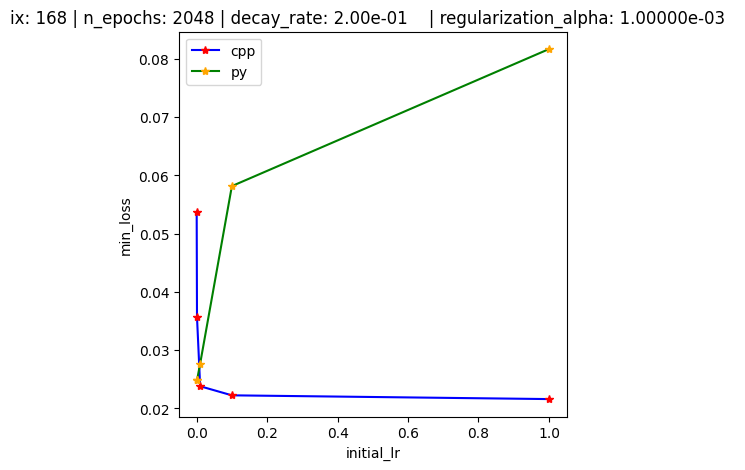

In [21]:
plot_lossVSlr(df, None)


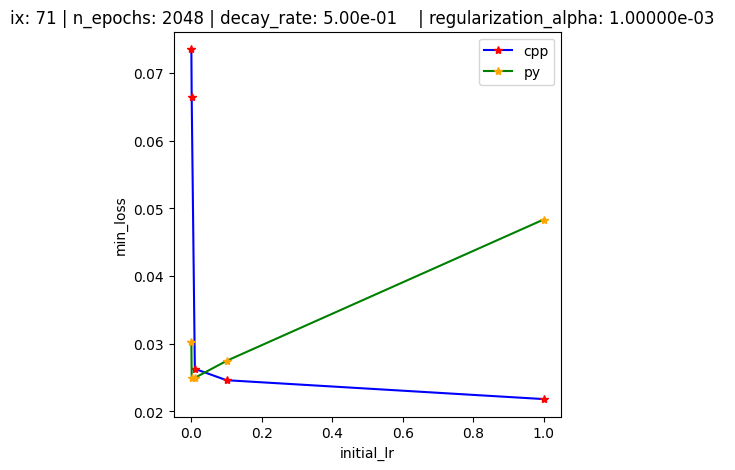

In [22]:
plot_lossVSlr(df, None)


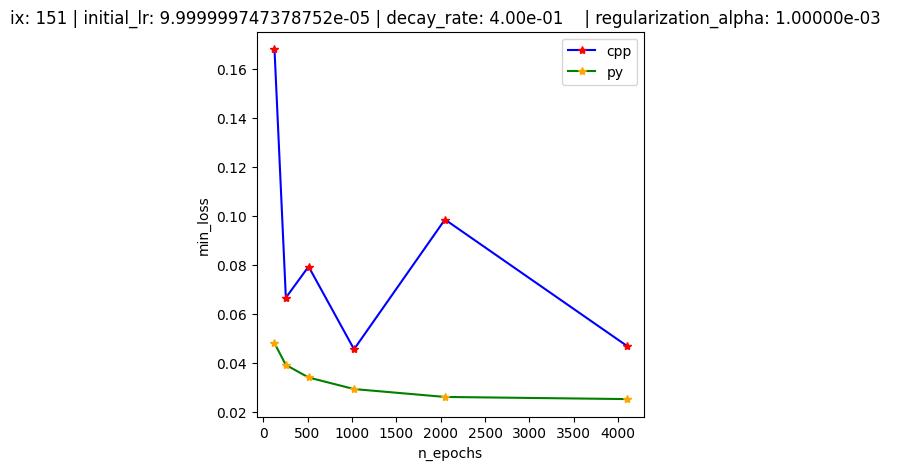

In [23]:
plot_lossVSepochs(df, None)


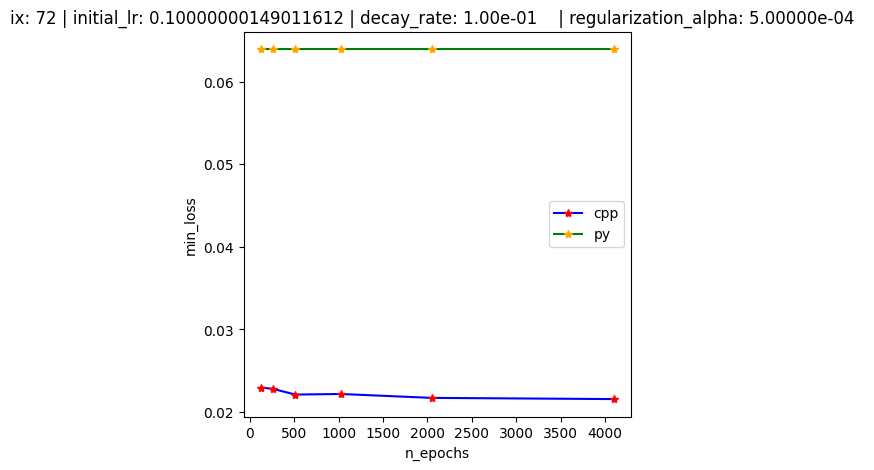

In [24]:
plot_lossVSepochs(df, None)
